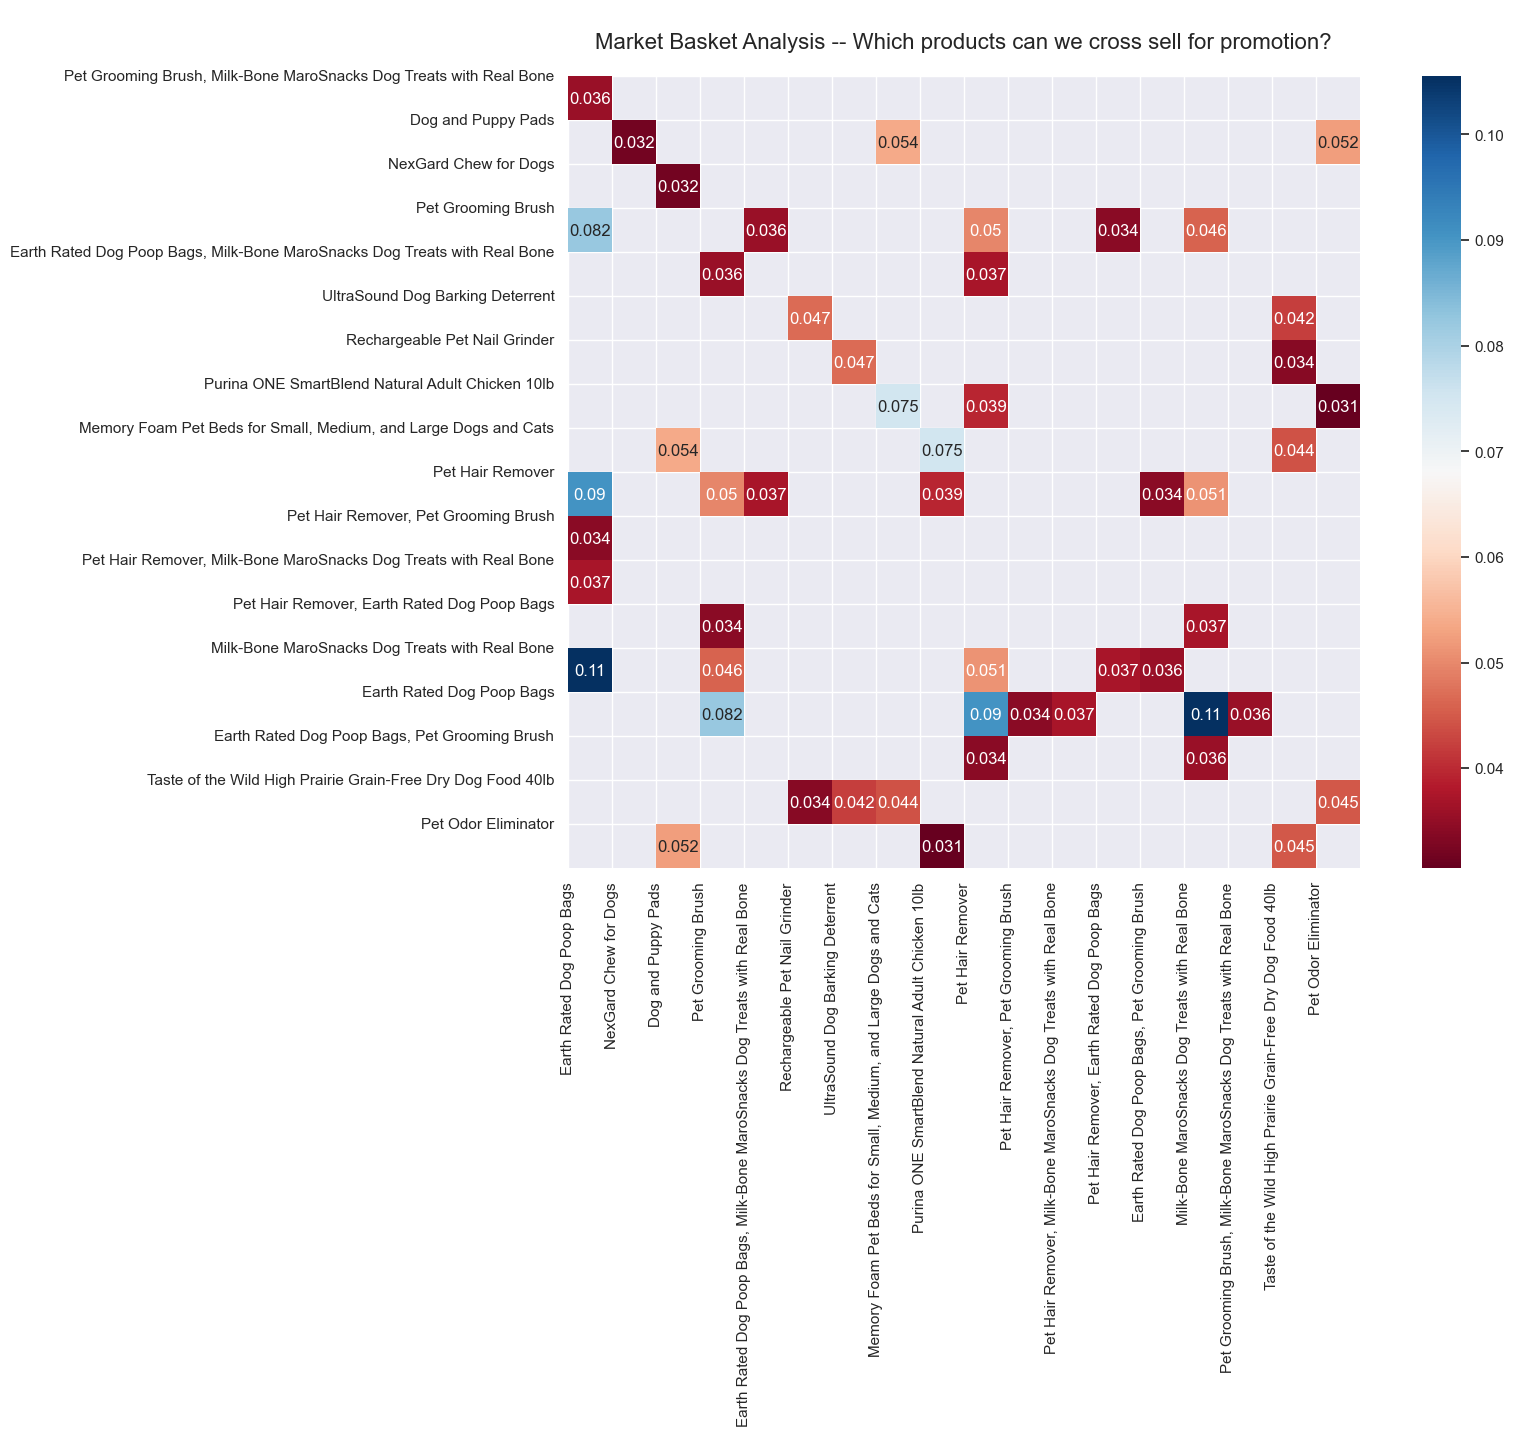

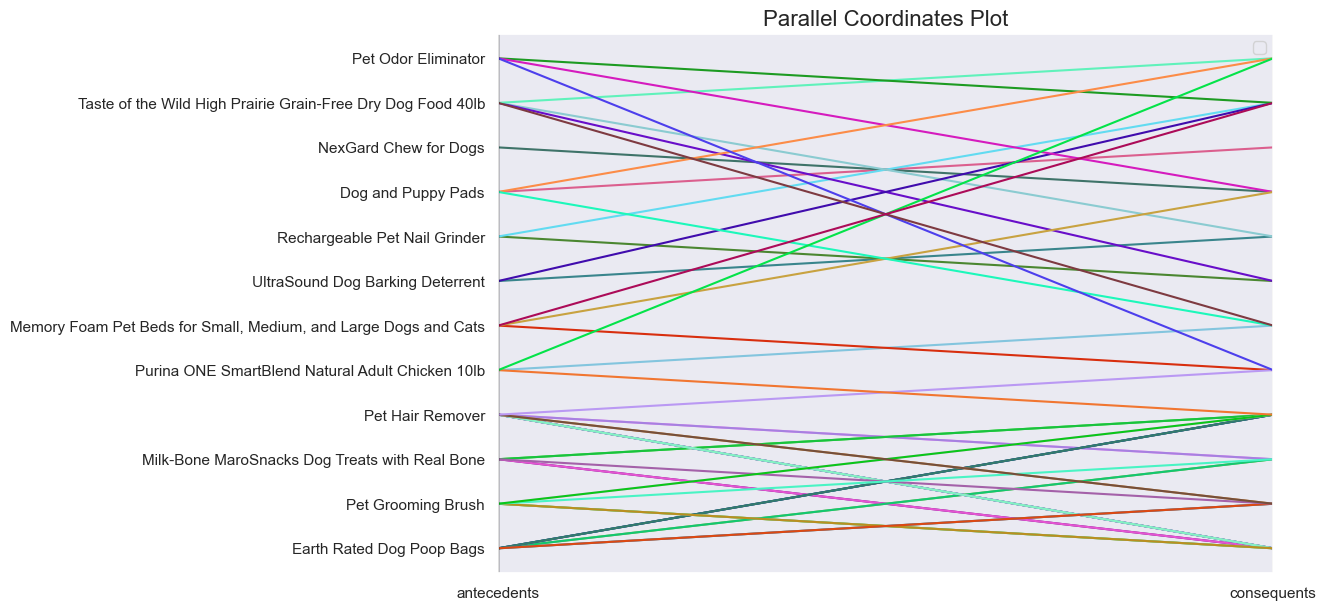

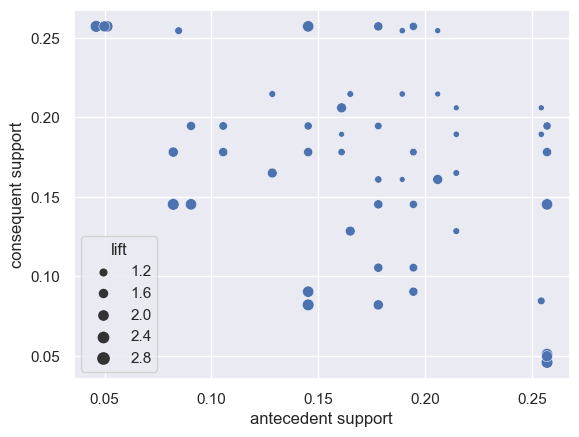

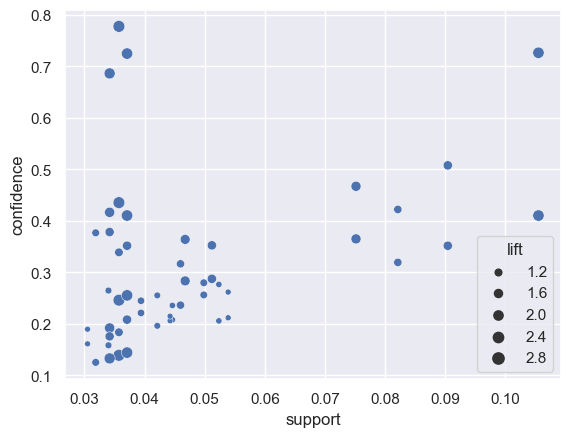

                                      antecedents                                     consequents      lift   support  confidence  antecedent support  consequent support  zhangs_metric
0                       Earth Rated Dog Poop Bags                              Pet Grooming Brush  3.022811  0.035742    0.138993            0.257148            0.045981       0.900829
1                              Pet Grooming Brush                       Earth Rated Dog Poop Bags  3.022811  0.035742    0.777311            0.045981            0.257148       0.701435
2  Milk-Bone MaroSnacks Dog Treats with Real Bone                       Earth Rated Dog Poop Bags  2.996120  0.035742    0.246011            0.145286            0.082110       0.779483
3                       Earth Rated Dog Poop Bags  Milk-Bone MaroSnacks Dog Treats with Real Bone  2.996120  0.035742    0.435294            0.082110            0.145286       0.725833
4                                Pet Hair Remover  Milk-Bone MaroSnacks Dog

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from pandas.plotting import parallel_coordinates

# Import dataset
df = pd.read_csv('fact_sales.csv')

# Inspect dataset
#print(df.head) [25065 rows x 8 columns]>

# Dropping nulls  
df = df.dropna()

# How much data was dropped? Approximately 20%
#print(df.head) [19996 rows x 8 columns]>

# Remove negative quantities which represent returns
df_ohne_neg = df[df['Quantity']>0]


# Summarize the original data with quantities grouped by invoice number and description
# Reshapes the resulting grouped data by converting 'Description' into column headers, and the corresponding quantities are filled in the respective cells.
basket_plus = df_ohne_neg.groupby(['Invoice No', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Invoice No')


# Encode the basket data into binary data that shows whether an items is bought (1) or not (0)
def encode_units (x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_encode_plus = (basket_plus.applymap(encode_units)).astype(bool)


# Filter out transactions with only 1 item since we're trying to make an association affinity analysis
basket_filter_plus = basket_encode_plus[basket_encode_plus.sum(axis=1) >=2]


# Apply the Apriori Algorithm
frequent_itemset_plus = apriori(basket_filter_plus, min_support=0.03,use_colnames=True).sort_values('support', ascending=False).reset_index(drop=True)


# Apply the association rules
frequent_itemset_plus_ass = association_rules(frequent_itemset_plus, metric='lift', min_threshold=1).sort_values('lift', ascending=False).reset_index(drop=True)


# Create heatmap
support_table = frequent_itemset_plus_ass.pivot(index='consequents', columns='antecedents', values='support')

# Set the figure size to make the heatmap wider
plt.figure(figsize=(16, 8))

# Convert the column names (antecedents) to strings to subscript product names from frozen set
support_table.columns = [', '.join(col) for col in support_table.columns]

# Convert the index (consequents) to strings to subscript product names from frozen set
support_table.index = [', '.join(index) for index in support_table.index]

# Plot the chart
sns.set()
heatmap_plot = sns.heatmap(data=support_table, annot=True, cmap='RdBu', square=True)
plt.xticks(range(len(support_table.columns)), support_table.columns, rotation=90)
plt.yticks(range(len(support_table.index)), support_table.index)
heatmap_plot.set_title('\nMarket Basket Analysis -- Which products can we cross sell for promotion?', pad=20, fontsize=16)

# Creat space between title and chart
plt.subplots_adjust(top=1.1)

# Display chart
plt.show()


# PARALLEL COORDINATES PLOT
plt.figure(figsize=(10, 7))
frequent_itemset_plus_ass['antecedents'] = frequent_itemset_plus_ass['antecedents'].apply(lambda antecedent: list(antecedent)[0])
frequent_itemset_plus_ass['consequents'] = frequent_itemset_plus_ass['consequents'].apply(lambda consequent: list(consequent)[0])
frequent_itemset_plus_ass['rule'] = frequent_itemset_plus_ass.index
coords = frequent_itemset_plus_ass[['antecedents', 'consequents', 'rule']]
parallel_coordinates(coords, 'rule')
plt.legend([])
plt.title("Parallel Coordinates Plot", fontsize=16)
plt.show()

# Metrics to provide information about the association rules between items in the dataset.
metrics = frequent_itemset_plus_ass[['antecedents', 'consequents', 'lift', 'support', 'confidence','antecedent support', 'consequent support','zhangs_metric']]
_ = sns.scatterplot(x='antecedent support', y='consequent support', size='lift', data=metrics)
plt.show()
_ = sns.scatterplot(x='support', y='confidence', size='lift', data=metrics)
plt.show()
#So what do we learn from scatterplots? First, they allow us to identify 
# natural thresholds in the data that would be difficult to discover via trial-and-error. 
# And second, they allow us to visualize the entire dataset, 
# which is infeasible using a heatmap. 
# Both of these benefits will allow us to refine the pruning process, 
# so that we can identify better rules. 

#What, if anything, can we learn from this scatterplot? 
# First, no antecedent or consequent support values exceed 0.25. 
# This means that any pruning we perform should focus on values within those bounds. 
# And second, most values appear to be clustered below 0.22 both on the x and y axis. 

pd.set_option('display.width', 1000)
print(metrics.head())

#print(frequent_itemset_plus_ass)